In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import re
import nltk
import itertools
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim import corpora, models
from collections import Counter
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jinu.jayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jinu.jayan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_csv("input/nyc-jobs.csv")

In [38]:
pd.set_option("display.max_columns", 28)
df.head(3)

,job_id,agency,posting_type,num_positions,business_title,civil_service_title,title_code_no,level,job_category,full-time_part-time_indicator,salary_range_from,salary_range_to,salary_frequency,work_location,...,job_description,minimum_qual_requirements,preferred_skills,additional_information,to_apply,hours_shift,work_location_1,recruitment_contact,residency_requirement,posting_date,post_until,posting_updated,process_date,residency_flag
0,87990,DEPARTMENT OF BUSINESS SERV.,Internal,1,Account Manager,CONTRACT REVIEWER (OFFICE OF L,40563,1,NaN,NaN,42405.00,65485.00,Annual,110 William St. N Y,...,Division of Economic & Financial Opportunity (...,1.\tA baccalaureate degree from an accredited ...,â€¢\tExcellent interpersonal and organizationa...,"Salary range for this position is: $42,405 - $...",NaN,NaN,NaN,NaN,New York City residency is generally required ...,2011-06-24T00:00:00.000,NaN,2011-06-24T00:00:00.000,2019-06-25T00:00:00.000,1
1,97899,DEPARTMENT OF BUSINESS SERV.,Internal,1,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",ADMINISTRATIVE BUSINESS PROMOT,10009,M3,NaN,F,60740.00,162014.00,Annual,110 William St. N Y,...,The New York City Department of Small Business...,1. A baccalaureate degree from an accredited c...,NaN,NaN,"In addition to applying through this website, ...",NaN,NaN,NaN,New York City residency is generally required ...,2012-01-26T00:00:00.000,NaN,2012-01-26T00:00:00.000,2019-06-25T00:00:00.000,1
2,132292,NYC HOUSING AUTHORITY,External,52,Maintenance Worker - Technical Services-Heatin...,MAINTENANCE WORKER,90698,0,Maintenance & Operations,F,51907.68,54580.32,Annual,Heating Mgt-Operations,...,"Under direct supervision, assist in the routin...",1. Three years of full-time satisfactory exper...,1. A High School Diploma or GED. 2. CDL Dri...,1. A Motor Vehicle Driverâ€™s License valid i...,"Click the ""Apply Now"" button.",NaN,NaN,NaN,NYCHA has no residency requirements.,2013-10-24T00:00:00.000,NaN,2013-12-12T00:00:00.000,2019-06-25T00:00:00.000,0


In [336]:
df.info()
#df.loc[:10, ['Full-Time/Part-Time indicator','Salary Frequency','Work Location','Division/Work Unit','Job Description','Minimum Qual Requirements','Preferred Skills','Additional Information','To Apply']]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2498 entries, 2 to 3110
Data columns (total 30 columns):
job_id                           2498 non-null int64
agency                           2498 non-null object
posting_type                     2498 non-null object
num_positions                    2498 non-null int64
business_title                   2498 non-null object
civil_service_title              2498 non-null object
title_code_no                    2498 non-null object
level                            2498 non-null object
job_category                     2498 non-null object
full-time_part-time_indicator    2498 non-null object
salary_range_from                2498 non-null float64
salary_range_to                  2498 non-null float64
salary_frequency                 2498 non-null object
work_location                    2498 non-null object
division_work_unit               2498 non-null object
job_description                  2498 non-null object
minimum_qual_requirements    

## Questions to be answered

1. Job category with most job openings 
2. Find Job categories which require a local residency
3. Find factors influencing mean salary
4. Preferred skills for jobs having high salary


In [239]:
### Format the column names
df.columns = [c.replace('# Of ', 'Num ').lower().rstrip().replace(' ','_').replace('/','_') for c in df.columns.tolist() ]

In [304]:
##Method to repalce special characters and return a single list with all the tokens in a corpus

def tokenizeSeries(series):
    print(series.shape)
    series = series.dropna()
    series = series.str.replace(' & ', ',').str.replace(',,', ',')
    catlist  = series.tolist()
    new_cat = [ x.split(',') for x in catlist]
    result = sum(new_cat, [])
    res = [x.lstrip() for x in result]
    return res

In [305]:
cat_list = tokenizeSeries(df['job_category'])
print("--------------")
print(cat_list)

(2498,)
--------------
['Maintenance', 'Operations', 'Maintenance', 'Operations', 'Finance', 'Accounting', 'Procurement', 'Health Public Safety', 'Inspections', 'Enforcement', 'Engineering', 'Architecture', 'Planning', 'Engineering', 'Architecture', 'Planning', 'Engineering', 'Architecture', 'Planning', 'Clerical', 'Administrative Support', 'Finance', 'Accounting', 'Procurement', 'Information Technology', 'Telecommunications', 'Information Technology', 'Telecommunications', 'Clerical', 'Administrative Support', 'Clerical', 'Administrative Support', 'Clerical', 'Administrative Support', 'Community', 'Business Services', 'Clerical', 'Administrative Support', 'Finance', 'Accounting', 'Procurement', 'Finance', 'Accounting', 'Procurement', 'Information Technology', 'Telecommunications', 'Clerical', 'Administrative Support', 'Clerical', 'Administrative Support Legal', 'Maintenance', 'Operations', 'Maintenance', 'Operations', 'Information Technology', 'Telecommunications', 'Information Techno

In [306]:
def getjobcategoryCount(df):
    cat_list = tokenizeSeries(df['job_category'])
    cat_count = Counter(cat_list)
    category = [c[0] for c in cat_count.most_common()]
    count = [c[1] for c in cat_count.most_common()]
    return category, count

(2498,)


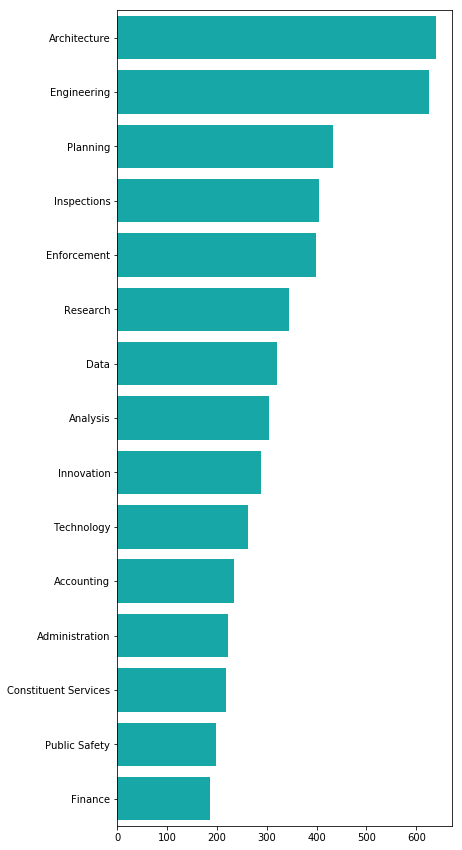

In [309]:
category, count = getjobcategoryCount(df)
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(x=count[:15], y=category[:15],  color="c")
plt.show()

## Find jobs with residency conditions

In [11]:
## Customise stopwords list for the specific task to solve
custom_stpwrds = list(gensim.parsing.preprocessing.STOPWORDS)
custom_stpwrds.remove('within')
custom_stpwrds.remove('is')
custom_stpwrds.remove('no')


In [12]:
stemmer = SnowballStemmer("english")
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in custom_stpwrds and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

def handleSpecificWords(str):
    str = re.sub('not require',  'not_require', str)
    #str = re.sub('New York City', 'NewYorkCity', str)
    return str

In [13]:
##Preprocess the text so as to indetify positvie and negative classes, then apply stemmign and lemmatization
#df['residency_requirement'] = df['residency_requirement'].apply(lambda x : re.sub('not require',  'not_require', x))
df['residency_requirement'] = df['residency_requirement'].apply(handleSpecificWords)
processed_docs = df['residency_requirement'].map(preprocess)

In [14]:
##Create BOW corpus
dictionary = gensim.corpora.Dictionary(processed_docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [15]:
##Create LDA model using tfidf of the corpus
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
#lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=2, id2word=dictionary, passes=2, workers=2)
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=2, id2word=dictionary, passes=2, workers=4)

In [253]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.050*"requir" + 0.037*"appli" + 0.037*"titl" + 0.037*"discuss" + 0.036*"interview" + 0.036*"time" + 0.036*"appoint" + 0.036*"determin" + 0.036*"continu" + 0.035*"elig"
Topic: 1 
Words: 0.198*"not_requir" + 0.193*"posit" + 0.055*"nycha" + 0.040*"requir" + 0.022*"citi" + 0.021*"westchest" + 0.020*"certain" + 0.020*"york" + 0.018*"repres" + 0.017*"work"


In [17]:
lda_model_tfidf.show_topics()

[(0,
  '0.052*"requir" + 0.039*"appoint" + 0.037*"general" + 0.037*"time" + 0.037*"continu" + 0.037*"discuss" + 0.036*"repres" + 0.036*"elig" + 0.036*"appli" + 0.036*"work"'),
 (1,
  '0.148*"not_requir" + 0.146*"posit" + 0.049*"nycha" + 0.038*"requir" + 0.032*"agenc" + 0.028*"suffolk" + 0.026*"within" + 0.024*"putnam" + 0.024*"rockland" + 0.024*"interview"')]

In [251]:
df['residency_requirement'][1055]

'New York City residency is generally required within 90 days of appointment. However, City Employees in certain titles who have worked for the City for 2 continuous years may also be eligible to reside in Nassau, Suffolk, Putnam, Westchester, Rockland, or Orange County. To determine if the residency requirement applies to you, please discuss with the agency representative at the time of interview.'

In [18]:
idx=3111
print(df['residency_requirement'][idx])
topic = sorted(lda_model_tfidf[bow_corpus[idx]],key=lambda tup: tup[1],reverse=True)[0][0]
if topic == 0:
    print("Class -> Residency required")
else:
    print("Class -> Residency is NOT required")

New York City Residency is not_required for this position.
Class -> Residency is NOT required


In [21]:
print(df['residency_requirement'][idx])
topic = sorted(lda_model_tfidf[bow_corpus[idx]],key=lambda tup: tup[1],reverse=True)[0][0]
if topic == 0:
    print("Class -> Residency required")
    #return 1
else:
    print("Class -> Residency is NOT required")
    #return 0

New York City Residency is not_required for this position.
Class -> Residency is NOT required


In [22]:
def findTopic(corpus):
    capture_topics = []
    for idx in range(len(corpus)):
        topic = sorted(lda_model_tfidf[bow_corpus[idx]],key=lambda tup: tup[1],reverse=True)[0][0]
        if topic == 0:
        #print("Class -> Residency required")
            capture_topics.append(1)
        else:
    #print("Class -> Residency is NOT required")
            capture_topics.append(0)
    return capture_topics

In [23]:
#df['residency_flag'] = 
topiclist = findTopic(bow_corpus)

In [24]:
df['residency_flag'] = topiclist

In [25]:
df['residency_flag'].value_counts()

1    1765
0    1348
Name: residency_flag, dtype: int64

In [29]:
category, count = getjobcategoryCount(df.loc[df.residency_flag == 1])

(1765,)


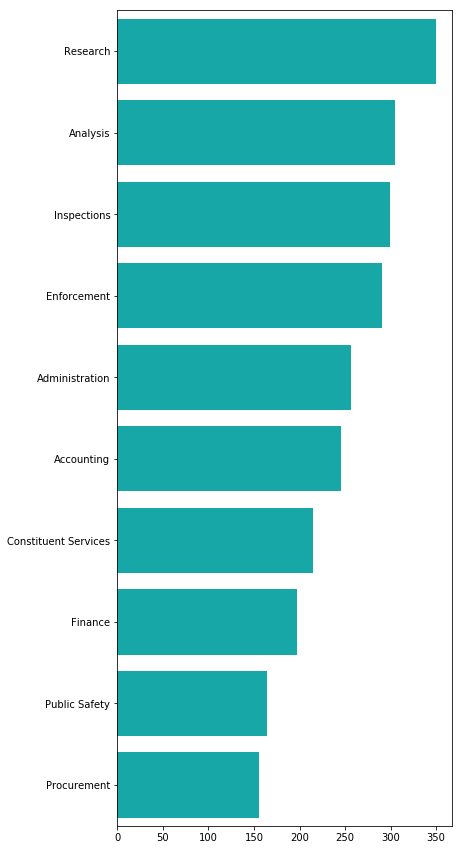

In [30]:
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(x=count[:10], y=category[:10],  color="c")
plt.show()

In [ ]:
df['mean_salary'] = (df['salary_range_from'] +  df['salary_range_to'])/2

In [46]:
df.loc[:10, ['salary_range_from', 'salary_range_to','salary_frequency','mean_salary']]

,salary_range_from,salary_range_to,salary_frequency,mean_salary
0,42405.00,65485.00,Annual,53945.0
1,60740.00,162014.00,Annual,111377.0
2,51907.68,54580.32,Annual,53244.0
3,51907.68,54580.32,Annual,53244.0
4,35.00,35.00,Hourly,35.0
5,35.00,35.00,Hourly,35.0
6,50598.00,85053.00,Annual,67825.5
7,50623.00,75083.00,Annual,62853.0
8,90000.00,110000.00,Annual,100000.0
9,62942.00,92249.00,Annual,77595.5


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113 entries, 0 to 3112
Data columns (total 30 columns):
job_id                           3113 non-null int64
agency                           3113 non-null object
posting_type                     3113 non-null object
num_positions                    3113 non-null int64
business_title                   3113 non-null object
civil_service_title              3113 non-null object
title_code_no                    3113 non-null object
level                            3113 non-null object
job_category                     3111 non-null object
full-time_part-time_indicator    2858 non-null object
salary_range_from                3113 non-null float64
salary_range_to                  3113 non-null float64
salary_frequency                 3113 non-null object
work_location                    3113 non-null object
division_work_unit               3113 non-null object
job_description                  3113 non-null object
minimum_qual_requirements    

In [87]:
df = df.dropna(subset = ['full-time_part-time_indicator'])
X = df.loc[:,['agency','posting_type','num_positions','civil_service_title','level','full-time_part-time_indicator','salary_frequency','residency_flag']]
y = df.loc[X.salary_frequency == 'Annual'].mean_salary



In [99]:
X = X.loc[X.salary_frequency == 'Annual']
X.shape
x_cols =X.columns

C:\Users\jinu.jayan\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [100]:
x_cols

Index(['agency', 'posting_type', 'num_positions', 'civil_service_title',
       'level', 'full-time_part-time_indicator', 'salary_frequency',
       'residency_flag'],
      dtype='object')

In [74]:
from numpy import loadtxt
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [92]:
X.head()

,agency,posting_type,num_positions,civil_service_title,level,full-time_part-time_indicator,salary_frequency,residency_flag
1,DEPARTMENT OF BUSINESS SERV.,Internal,1,ADMINISTRATIVE BUSINESS PROMOT,M3,F,Annual,1
2,NYC HOUSING AUTHORITY,External,52,MAINTENANCE WORKER,0,F,Annual,0
3,NYC HOUSING AUTHORITY,Internal,52,MAINTENANCE WORKER,0,F,Annual,0
6,DEPT OF HEALTH/MENTAL HYGIENE,Internal,1,PROCUREMENT ANALYST,3,F,Annual,1
7,DEPT OF ENVIRONMENT PROTECTION,Internal,1,ASSOCIATE CHEMIST,2,F,Annual,1


In [94]:
X=X.apply(preprocessing.LabelEncoder().fit_transform)

In [95]:
X.head(3)

,agency,posting_type,num_positions,civil_service_title,level,full-time_part-time_indicator,salary_frequency,residency_flag
1,10,1,0,13,11,0,0,1
2,43,0,23,204,0,0,0,0
3,43,1,23,204,0,0,0,0


In [97]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size = 0.2, random_state = 42)
X_train.shape

(2072, 8)

In [98]:
rf = RandomForestRegressor(n_estimators = 500, random_state = 42)
rf.fit(X_train, Y_train.ravel());
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - Y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'Rupees')

Mean Absolute Error: 4882.66 Rupees


In [101]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x_cols, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: level                Importance: 0.56
Variable: civil_service_title  Importance: 0.22
Variable: residency_flag       Importance: 0.11
Variable: agency               Importance: 0.09
Variable: num_positions        Importance: 0.02
Variable: posting_type         Importance: 0.0
Variable: full-time_part-time_indicator Importance: 0.0
Variable: salary_frequency     Importance: 0.0


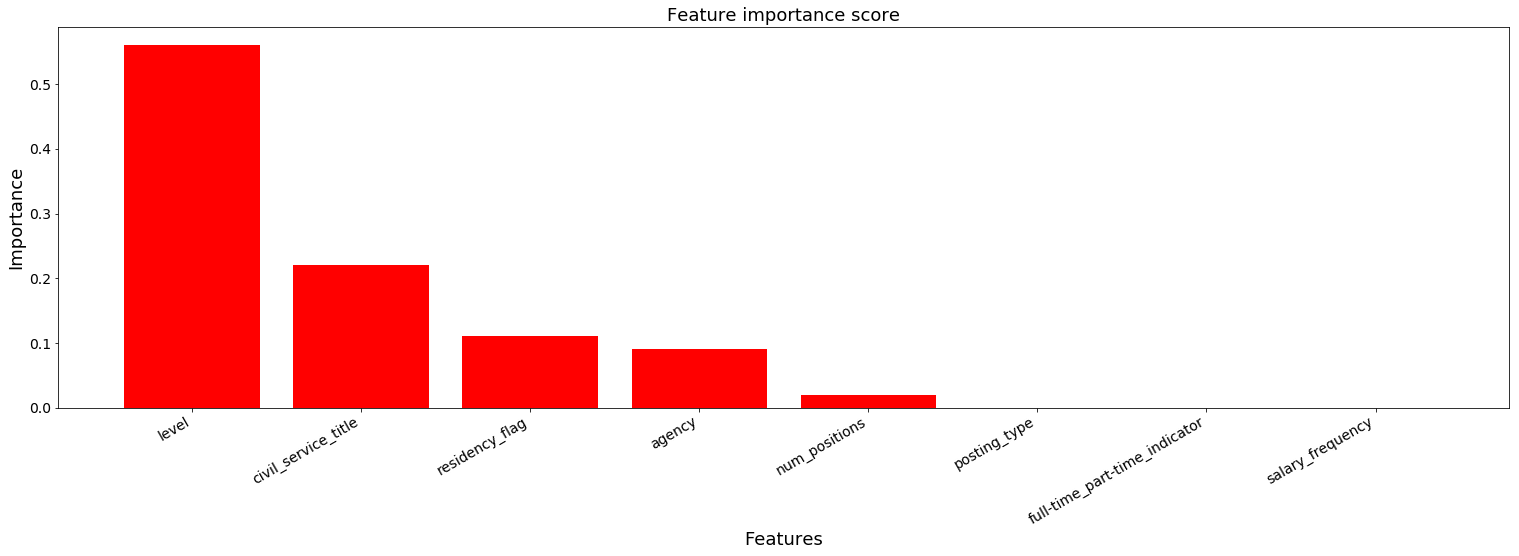

In [102]:
features = [f[0] for f in feature_importances]
values = [f[1] for f in feature_importances]
fig,ax = plt.subplots(1,1,figsize=(26,7))

ax.bar(features[:20], values[:20],color='r')

ax.set_xlabel('Features',fontsize=18)
ax.set_ylabel('Importance',fontsize=18)

ax.set_title('Feature importance score',fontsize=18)
ax.tick_params(labelsize=14)
#axes[1].set_title('Mode cost analysis')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

## Job categories with highest salary

In [118]:
df.loc[(df.mean_salary >= df.mean_salary.quantile(0.75)) & (df.level == '0')].head()

,job_id,agency,posting_type,num_positions,business_title,civil_service_title,title_code_no,level,job_category,full-time_part-time_indicator,salary_range_from,salary_range_to,salary_frequency,work_location,...,minimum_qual_requirements,preferred_skills,additional_information,to_apply,hours_shift,work_location_1,recruitment_contact,residency_requirement,posting_date,post_until,posting_updated,process_date,residency_flag,mean_salary
8,151131,NYC HOUSING AUTHORITY,External,1,Cost Estimating Manager,ADMINISTRATIVE STAFF ANALYST (,1002D,0,"Engineering, Architecture, & Planning",F,90000.0,110000.0,Annual,CP Cap Plan-Technical Planning,...,1. A master's degree from an accredited colleg...,1. Five years of managerial and supervisory e...,SPECIAL INSTRUCTIONS FOR NYCHA EMPLOYEES: N...,"Click the ""Apply Now"" button.",NaN,NaN,NaN,NYCHA has no residency requirements.,2014-06-25T00:00:00.000,NaN,2014-07-07T00:00:00.000,2019-06-25T00:00:00.000,0,100000.0
107,243586,DEPARTMENT OF TRANSPORTATION,Internal,1,Admin Engineer (NM),ADM ENGINEER (NON MGRL),1001A,0,"Engineering, Architecture, & Planning",F,48535.0,132061.0,Annual,55 Water St Ny Ny,...,A valid New York State License as a Profession...,Ability to communicate effectively in verbal a...,TO BE APPOINTED TO AN ADMINISTRATIVE ENGINEER ...,Resumes may be submitted using one of the foll...,35hrs,TO BE DETERMINED,NaN,New York City Residency is not_required for th...,2016-06-27T00:00:00.000,NaN,2016-08-02T00:00:00.000,2019-06-25T00:00:00.000,0,90298.0
108,243586,DEPARTMENT OF TRANSPORTATION,External,1,Admin Engineer (NM),ADM ENGINEER (NON MGRL),1001A,0,"Engineering, Architecture, & Planning",F,48535.0,132061.0,Annual,55 Water St Ny Ny,...,A valid New York State License as a Profession...,Ability to communicate effectively in verbal a...,TO BE APPOINTED TO AN ADMINISTRATIVE ENGINEER ...,Resumes may be submitted using one of the foll...,35hrs,TO BE DETERMINED,NaN,New York City Residency is not_required for th...,2016-06-27T00:00:00.000,NaN,2016-08-02T00:00:00.000,2019-06-25T00:00:00.000,0,90298.0
160,268037,DEPT OF ENVIRONMENT PROTECTION,External,1,"Accountable Manager, CSO LTCP Program",ADMINISTRATIVE PROJECT MANAGER,8300B,0,"Engineering, Architecture, & Planning",F,48535.0,134433.0,Annual,96-05 Horace Harding Expway,...,1. A baccalaureate degree from an accredited c...,1.\tA valid NYS Professional Engineers license...,NaN,"To apply click ""Apply Now"".",NaN,NaN,NaN,New York City Residency is not_required for th...,2016-11-07T00:00:00.000,NaN,2016-11-10T00:00:00.000,2019-06-25T00:00:00.000,0,91484.0
161,268037,DEPT OF ENVIRONMENT PROTECTION,Internal,1,"Accountable Manager, CSO LTCP Program",ADMINISTRATIVE PROJECT MANAGER,8300B,0,"Engineering, Architecture, & Planning",F,48535.0,134433.0,Annual,96-05 Horace Harding Expway,...,1. A baccalaureate degree from an accredited c...,1.\tA valid NYS Professional Engineers license...,NaN,"To apply click ""Apply Now"".",NaN,NaN,NaN,New York City Residency is not_required for th...,2016-11-07T00:00:00.000,NaN,2016-11-10T00:00:00.000,2019-06-25T00:00:00.000,0,91484.0


In [110]:
df.mean_salary.median()

69283.5

(626,)


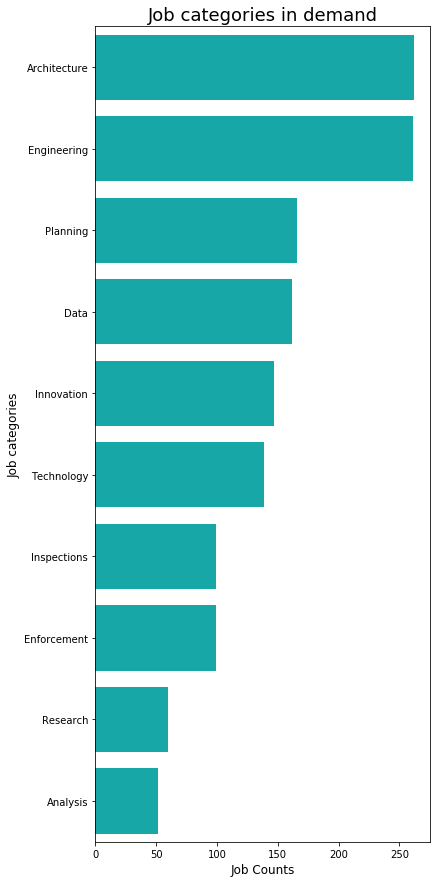

In [335]:
category, count = getjobcategoryCount(df.loc[(df.mean_salary >= df.mean_salary.quantile(0.75))])
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(x=count[:10], y=category[:10],  color="c")
ax.set_title('Job categories in demand',fontsize=18)
ax.set_xlabel('Job Counts',fontsize=12)
ax.set_ylabel('Job categories',fontsize=12)
plt.show()

## Preferred skills for high and low salary

In [355]:
#list(df.loc[(df.mean_salary >= df.mean_salary.quantile(0.75))].preferred_skills[:5])

In [354]:
#list(df.loc[(df.mean_salary <= df.mean_salary.quantile(0.25))].preferred_skills[:10].replace('[^a-zA-Z ]','', regex = True).str.lower())

In [351]:
#df['residency_requirement'] = df['residency_requirement'].apply(handleSpecificWords)
df = df.dropna(subset=['preferred_skills'])
df['preferred_skills'] = df.preferred_skills.astype(str)
wordcount_high_sal = wordcount(df.loc[(df.mean_salary >= df.mean_salary.quantile(0.75))].preferred_skills.replace('[^a-zA-Z ]',' ', regex = True).str.lower())
#processed_skill_text = cleaned_text.map(preprocess)

In [337]:
### Function to evaluate word count for each word in the corpus
def wordcount(cleaned_text):
    custom_stpwrds = list(gensim.parsing.preprocessing.STOPWORDS)
    custwrds = ['excellent','knowledge','skills','ability']
    custom_stpwrds.extend(custwrds)
    processed_skill_text = cleaned_text.map(preprocess)
    text_list = list(processed_skill_text)
    dictionary_skills = gensim.corpora.Dictionary(text_list)
    merged = list(itertools.chain.from_iterable(text_list))
    bow_corpus = dictionary_skills.doc2bow(merged)
    word_count = []
    for wrd,idx in dictionary_skills.token2id.items():
    #print(bow_dict[idx] )
        word_count.append(tuple([wrd,bow_dict[idx]]))
    return dict(sorted(word_count, key = lambda x : x[1], reverse = True))

In [340]:
def plot_wordcloud(data, freq=False):
    if freq:
        print("here")
        #wordcloud = WordCloud(background_color='white',max_words=100,width=512, height=512).fit_words(data)
        #wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").fit_words(data)
        wordcloud = WordCloud(width=1600, height=800,max_words=100).fit_words(data)
        
    else:
        wordcloud = WordCloud(background_color='white',
                     width=1024, height=720).generate(data)
    
    plt.figure( figsize=(16,8), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

here


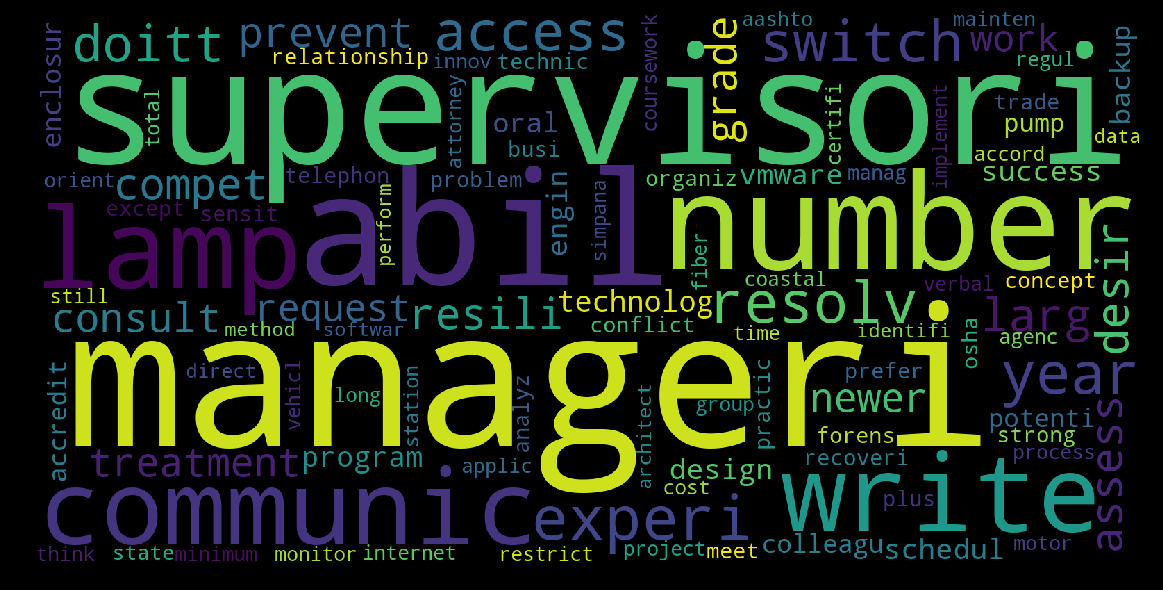

In [353]:
plot_wordcloud(wordcount_high_sal, freq=True)

In [347]:
wordcount_low_sal = wordcount(df.loc[(df.mean_salary <= df.mean_salary.quantile(0.20))].preferred_skills.replace('[^a-zA-Z ]',' ', regex = True).str.lower())
#processed_skill_text = cleaned_text.map(preprocess)

here


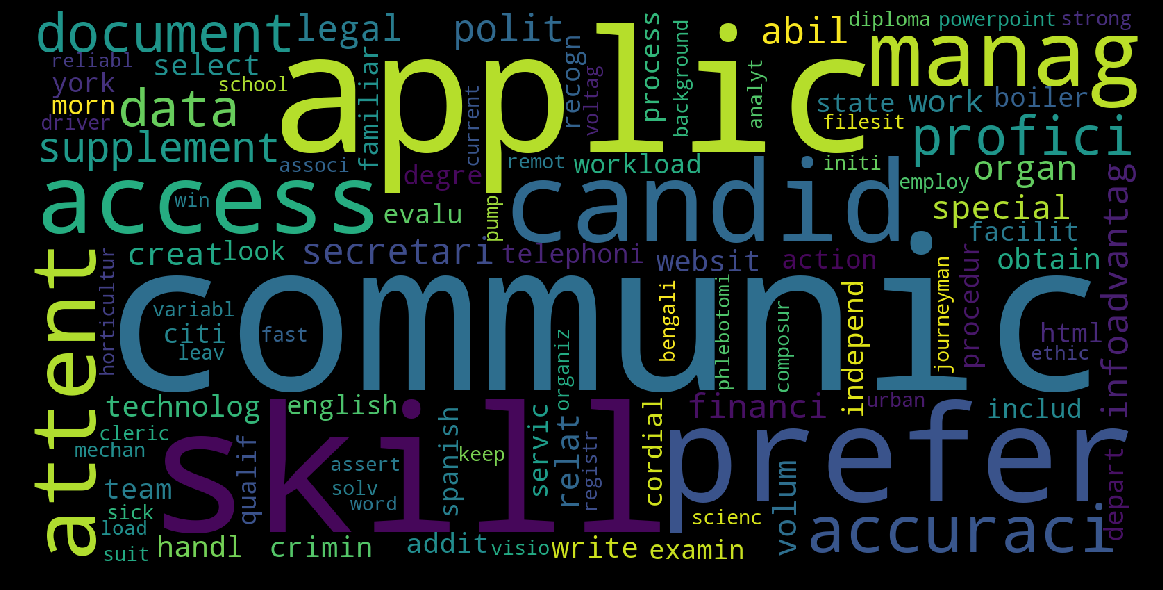

In [348]:
plot_wordcloud(wordcount_low_sal, freq=True)

## Inference:

From the above two plots we can see a pattern like 
High salary skills - Experience in managerial and supervisor roles with some accreditions. Knowledge of simpana, vmware, data backup.

Low salary - Secreterial and documentaiton type of jobs.jobs related to managing pumps and boilers. with diploma and powepoint skills. Also some language related openings like Bengali and Spanish.